In [1]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')




data_dir = '/kaggle/input/mango-leaf-disease-dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [2]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)



batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)



class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation=None
)

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.
102967424/102967424 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 batch_normalization (BatchN  (None, 1000)             4000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               256256    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense

Epoch 1/10
100/100 [==============================] - 36s 303ms/step - loss: 6.8116 - accuracy: 0.8681 - val_loss: 5.7567 - val_accuracy: 0.9542
Epoch 2/10
100/100 [==============================] - 8s 84ms/step - loss: 4.9442 - accuracy: 0.9631 - val_loss: 4.2380 - val_accuracy: 0.9812
Epoch 3/10
100/100 [==============================] - 8s 80ms/step - loss: 3.7185 - accuracy: 0.9794 - val_loss: 3.1804 - val_accuracy: 0.9896
Epoch 4/10
100/100 [==============================] - 8s 81ms/step - loss: 2.8019 - accuracy: 0.9875 - val_loss: 2.3916 - val_accuracy: 0.9937
Epoch 5/10
100/100 [==============================] - 8s 83ms/step - loss: 2.1129 - accuracy: 0.9881 - val_loss: 1.7940 - val_accuracy: 0.9958
Epoch 6/10
100/100 [==============================] - 8s 83ms/step - loss: 1.6050 - accuracy: 0.9909 - val_loss: 1.3608 - val_accuracy: 0.9937
Epoch 7/10
100/100 [==============================] - 8s 78ms/step - loss: 1.2253 - accuracy: 0.9919 - val_loss: 1.0475 - val_accuracy: 0.99

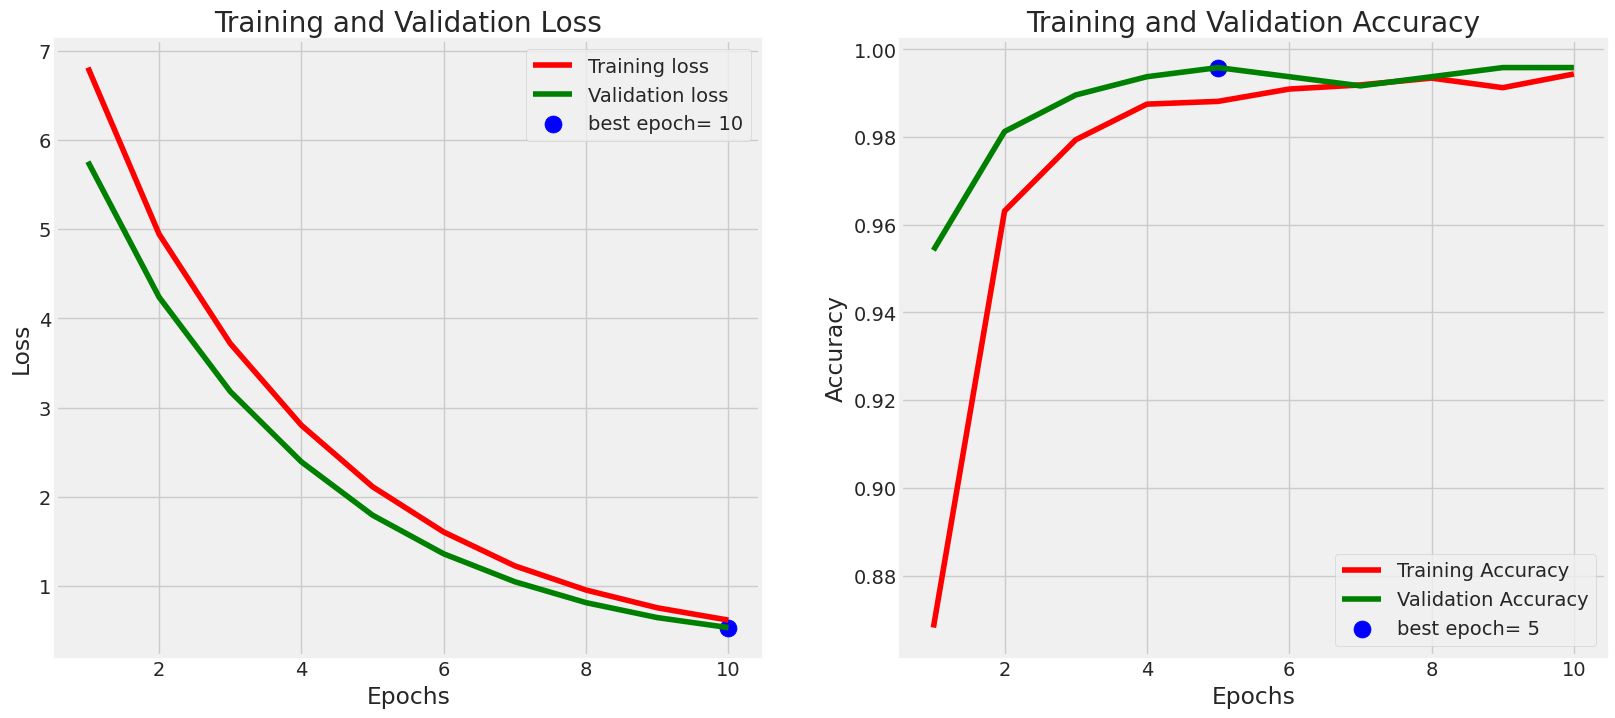

4/4 [==============================] - 3s 519ms/step - loss: 0.5393 - accuracy: 0.9937
Train Loss:  0.5186076760292053
Train Accuracy:  1.0
--------------------
Validation Loss:  0.5352665781974792
Validation Accuracy:  1.0
--------------------
Test Loss:  0.5392866134643555
Test Accuracy:  0.9937499761581421


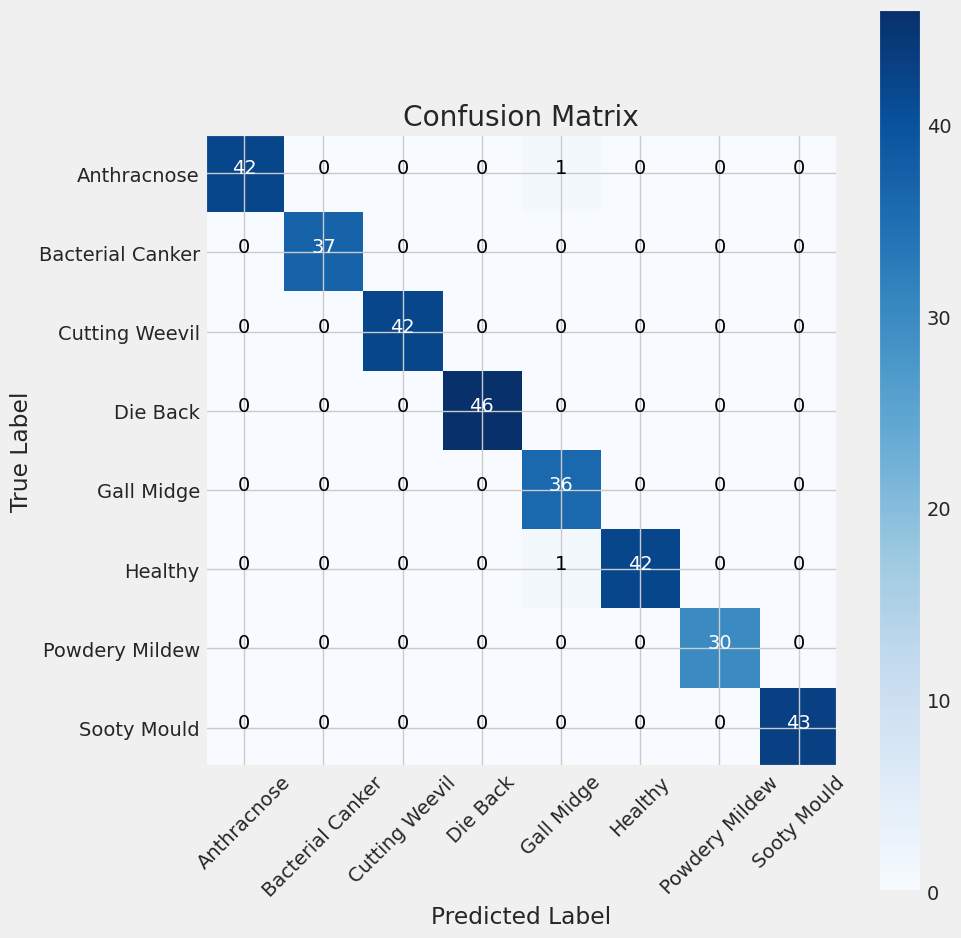

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.98      0.99        43
Bacterial Canker       1.00      1.00      1.00        37
  Cutting Weevil       1.00      1.00      1.00        42
        Die Back       1.00      1.00      1.00        46
      Gall Midge       0.95      1.00      0.97        36
         Healthy       1.00      0.98      0.99        43
  Powdery Mildew       1.00      1.00      1.00        30
     Sooty Mould       1.00      1.00      1.00        43

        accuracy                           0.99       320
       macro avg       0.99      0.99      0.99       320
    weighted avg       0.99      0.99      0.99       320



In [3]:
batch_size = 128   # set batch size for training
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, validation_steps= None, shuffle= False)




tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()





ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)



g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [4]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

4/4 [==============================] - 1s 208ms/step - loss: 0.5393 - accuracy: 0.9937
Test Loss: 0.5392866134643555
Test Accuracy: 0.9937499761581421


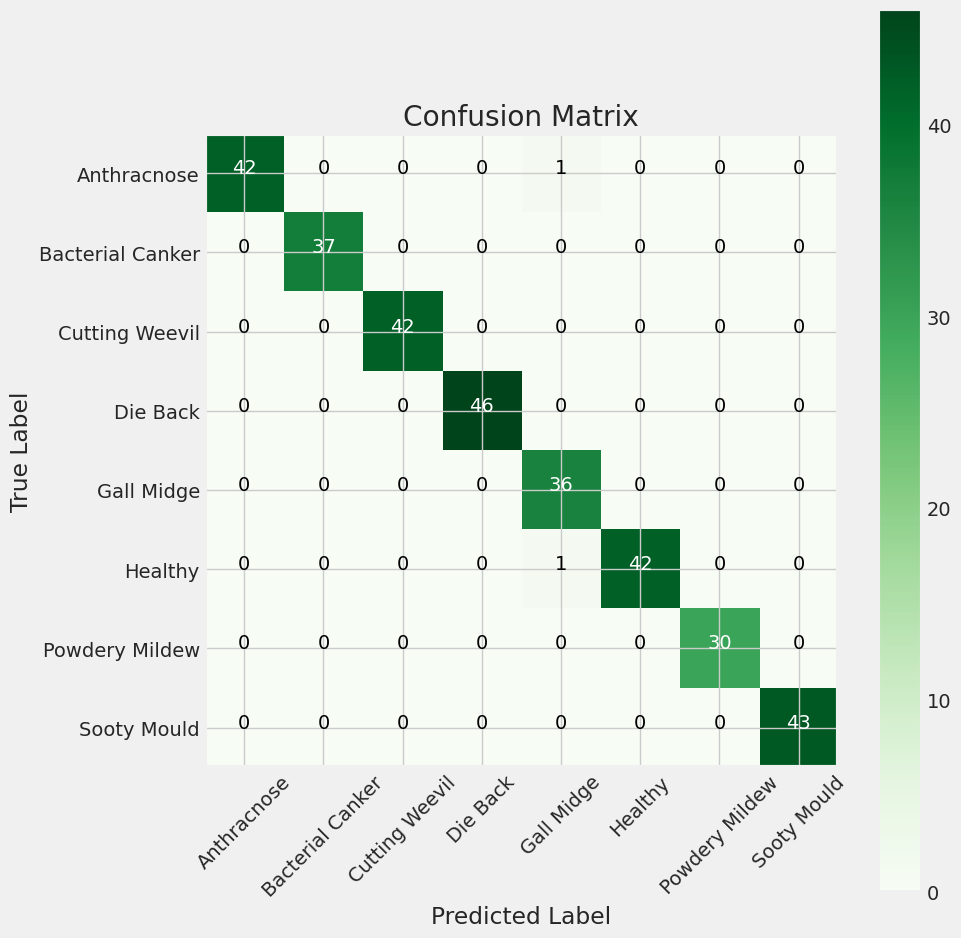

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming `test_gen`, `y_pred`, and `classes` are defined

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)  # Change colormap to Greens
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


**RESNET 50 **

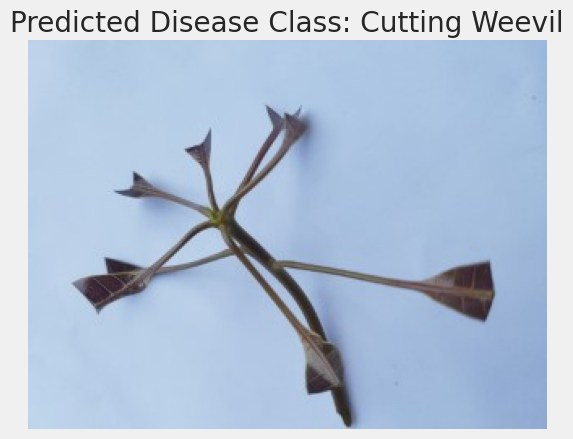

In [7]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define a function to extract the disease class name from the file path
def extract_disease_class(file_path):
    return os.path.basename(os.path.dirname(file_path))

# Specify the path to your image
image_path = "/kaggle/input/mango-leaf-disease-dataset/Cutting Weevil/20211011_131104 (Custom).jpg"

# Extract the disease class name from the file path
predicted_disease_class = extract_disease_class(image_path)

# Load the image
img = image.load_img(image_path)
img_array = image.img_to_array(img)

# Display the image along with the predicted disease class name
plt.imshow(img_array.astype('uint8'))
plt.title(f'Predicted Disease Class: {predicted_disease_class}')
plt.axis('off')
plt.show()
